In [24]:
import os
import numpy as np
import scipy.io
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from kymatio.numpy import Scattering1D
from scipy import signal
from itertools import product
import time

In [25]:
# --- Paths ---
data_dir = 'training2017/params_data/trainingForParams'
label_df = pd.read_csv("training2017/training2017/REFERENCE.csv", header=None, names=['filename', 'label'])
label_map = dict(zip(label_df['filename'], label_df['label']))

In [26]:
# --- Settings ---
fs = 300
samples_to_remove = 600
standard_ecg_length = 7800

In [27]:
# --- Preprocessing ---
def bandpass_filter(data, lowcut=0.05, highcut=100, fs=300, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)


In [28]:
# --- Parameter Grid ---
J_values = [5, 6, 7, 8]
Q_values = [6, 8, 10, 12]

# Dictionary to store results
results = {}

In [29]:
# Load and preprocess all ECG signals once
print("Loading and preprocessing ECG signals...")
preprocessed_signals = []
labels = []
file_list = sorted([f for f in os.listdir(data_dir) if f.endswith('.mat')])

for file in file_list:
    try:
        mat_path = os.path.join(data_dir, file)
        mat_contents = scipy.io.loadmat(mat_path)
        ecg = mat_contents['val'].squeeze()
        
        # Apply bandpass filter
        filtered = bandpass_filter(ecg)
        
        # Trim edges
        trimmed = filtered[samples_to_remove:-samples_to_remove]
        
        # Z-score normalize the signal
        trimmed = (trimmed - np.mean(trimmed)) / (np.std(trimmed) + 1e-10)
        
        # Standardize length
        if len(trimmed) < standard_ecg_length:
            standardized_ecg = np.pad(trimmed, (0, standard_ecg_length - len(trimmed)), mode='constant')
        else:
            start_idx = (len(trimmed) - standard_ecg_length) // 2
            standardized_ecg = trimmed[start_idx:start_idx + standard_ecg_length]
        
        preprocessed_signals.append(standardized_ecg)
        labels.append(label_map[file.replace('.mat', '')])
    except Exception as e:
        print(f"Error processing {file}: {e}")

Loading and preprocessing ECG signals...


In [30]:
# Convert labels to numeric
le = LabelEncoder()
y = le.fit_transform(labels)
print(f"Loaded {len(preprocessed_signals)} ECG signals")
print(f"Number of classes: {len(le.classes_)}")
print(f"Class distribution: {np.bincount(y)}")

Loaded 2561 ECG signals
Number of classes: 4
Class distribution: [ 230 1509  737   85]


In [31]:
# --- Grid Search ---
best_f1 = 0
best_params = None
start_time = time.time()

for J, Q in product(J_values, Q_values):
    print(f"\n=== Testing parameters: J={J}, Q={Q} ===")
    param_key = f"J{J}_Q{Q}"
    
    # Extract features using current J, Q
    features = []
    for signal in preprocessed_signals:
        scattering = Scattering1D(J=J, Q=Q, shape=(standard_ecg_length,))
        coeffs = scattering(np.array(signal, dtype=np.float32))
        coeffs = coeffs.reshape(coeffs.shape[0], -1).flatten()
        features.append(coeffs)
    
    X = np.array(features)
    
    # Run cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_f1_scores = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=7, random_state=fold)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        fold_f1 = f1_score(y_test, y_pred, average='weighted')
        fold_f1_scores.append(fold_f1)
        
        print(f"Fold {fold} - F1 Score: {fold_f1:.4f}")
    
    # Calculate average F1 score
    avg_f1 = np.mean(fold_f1_scores)
    results[param_key] = avg_f1
    print(f"Average F1 Score for J={J}, Q={Q}: {avg_f1:.4f}")
    
    # Update best parameters
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_params = (J, Q)

elapsed_time = time.time() - start_time


=== Testing parameters: J=5, Q=6 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.250558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4027725
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 15795
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.5609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.103603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4027725
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15795
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.767659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4027725
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15795
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.5621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.762519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4027725
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15795
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.5503
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.031867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4027725
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15795
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.5863
Average F1 Score for J=5, Q=6: 0.5722

=== Testing parameters: J=5, Q=8 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.908880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5205060
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 20412
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.5765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.723995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5205060
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 20412
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.573161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5205060
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 20412
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.5798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.628955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5205060
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 20412
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.5655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.342824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5205060
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 20412
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.5668
Average F1 Score for J=5, Q=8: 0.5796

=== Testing parameters: J=5, Q=10 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.704837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6196500
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 24300
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.5591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.765596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6196500
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 24300
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.5797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.924600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6196500
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 24300
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.5653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.045287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6196500
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 24300
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.5523
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.929433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6196500
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 24300
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.5749
Average F1 Score for J=5, Q=10: 0.5662

=== Testing parameters: J=5, Q=12 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.136748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7125975
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 27945
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.5484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.339800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7125975
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 27945
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.5902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.545492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7125975
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 27945
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.5660
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.380084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7125975
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 27945
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.5618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.308191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7125975
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 27945
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.5973
Average F1 Score for J=5, Q=12: 0.5727

=== Testing parameters: J=6, Q=6 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.356260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2962080
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 11616
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.6407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.311147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2962080
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 11616
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.176387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2962080
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 11616
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.6164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.165730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2962080
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 11616
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.5979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.186620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2962080
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 11616
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.6250
Average F1 Score for J=6, Q=6: 0.6207

=== Testing parameters: J=6, Q=8 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.216085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887730
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 15246
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.6266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.707225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887730
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15246
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.830124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887730
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15246
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.6308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.745594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887730
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15246
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.003123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887730
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15246
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.6299
Average F1 Score for J=6, Q=8: 0.6239

=== Testing parameters: J=6, Q=10 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.415670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4689960
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 18392
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.6304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.168432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4689960
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 18392
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.191760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4689960
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 18392
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.6346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.111709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4689960
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 18392
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6123
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.123782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4689960
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 18392
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.6209
Average F1 Score for J=6, Q=10: 0.6281

=== Testing parameters: J=6, Q=12 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.764693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5461335
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 21417
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.6247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.496541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5461335
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 21417
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.495734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5461335
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 21417
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.5886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.566061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5461335
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 21417
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.406676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5461335
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 21417
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.6119
Average F1 Score for J=6, Q=12: 0.6089

=== Testing parameters: J=7, Q=6 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.747995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068815
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 8113
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.6699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.694257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068815
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 8113
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.688976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068815
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 8113
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.6896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.772962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068815
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 8113
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.682518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068815
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 8113
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.6794
Average F1 Score for J=7, Q=6: 0.6776

=== Testing parameters: J=7, Q=8 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.114123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2737680
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 10736
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.6561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.068283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2737680
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 10736
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.107974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2737680
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 10736
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.6750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.993275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2737680
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 10736
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6460
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.025763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2737680
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 10736
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.6717
Average F1 Score for J=7, Q=8: 0.6620

=== Testing parameters: J=7, Q=10 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.649940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3328770
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 13054
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.6722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.483355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3328770
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 13054
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.420793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3328770
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 13054
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.6777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.637228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3328770
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 13054
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.404694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3328770
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 13054
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.6660
Average F1 Score for J=7, Q=10: 0.6719

=== Testing parameters: J=7, Q=12 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.320650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3904305
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 15311
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.6530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.782503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3904305
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15311
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.736493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3904305
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15311
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.6571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.744653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3904305
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15311
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6303
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.754784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3904305
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 15311
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.6562
Average F1 Score for J=7, Q=12: 0.6503

=== Testing parameters: J=8, Q=6 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.451549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 5456
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.7258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.422442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.7194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.421551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.7332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.422030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6786
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.422198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.6927
Average F1 Score for J=8, Q=6: 0.7099

=== Testing parameters: J=8, Q=8 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.581968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849770
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 7254
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.7040
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.694804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849770
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 7254
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.7221
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.609485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849770
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 7254
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.7028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.592236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849770
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 7254
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.607942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1849770
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 7254
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.812447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2260830
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 8866
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.7060
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.868302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2260830
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 8866
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.830211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2260830
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 8866
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.6922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.734098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2260830
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 8866
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.747390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2260830
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 8866
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 - F1 Score: 0.7036
Average F1 Score for J=8, Q=10: 0.6910

=== Testing parameters: J=8, Q=12 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.097859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2663985
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 10447
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528726
[LightGBM] [Info] Start training from score -1.246193
[LightGBM] [Info] Start training from score -3.405111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 - F1 Score: 0.7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.986326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2663985
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 10447
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 - F1 Score: 0.6948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.998854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2663985
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 10447
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 - F1 Score: 0.7029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.975996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2663985
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 10447
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.529214
[LightGBM] [Info] Start training from score -1.244985
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 - F1 Score: 0.6651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.109302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2663985
[LightGBM] [Info] Number of data points in the train set: 2049, number of used features: 10447
[LightGBM] [Info] Start training from score -2.410171
[LightGBM] [Info] Start training from score -0.528386
[LightGBM] [Info] Start training from score -1.246681
[LightGBM] [Info] Start training from score -3.405599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== GRID SEARCH RESULTS ===
Total runtime: 42004.85 seconds

All parameter combinations:
J8_Q6: 0.7099
J8_Q8: 0.7056
J8_Q10: 0.6910
J8_Q12: 0.6888
J7_Q6: 0.6776
J7_Q10: 0.6719
J7_Q8: 0.6620
J7_Q12: 0.6503
J6_Q10: 0.6281
J6_Q8: 0.6239
J6_Q6: 0.6207
J6_Q12: 0.6089
J5_Q8: 0.5796
J5_Q12: 0.5727
J5_Q6: 0.5722
J5_Q10: 0.5662

Best parameters: J=8, Q=6
Best average F1 score: 0.7099


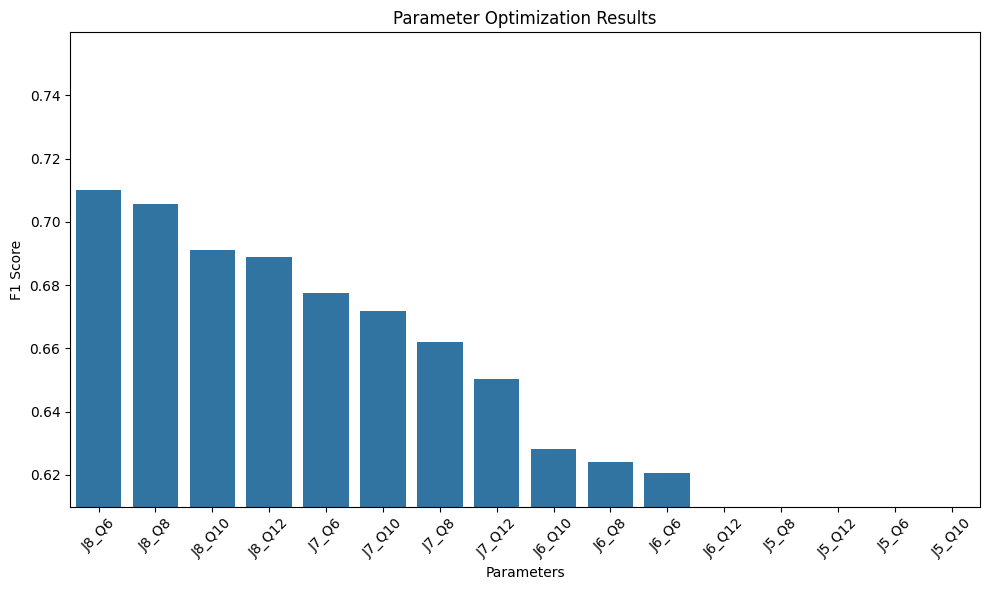

In [32]:
# --- Print Final Results ---
print("\n=== GRID SEARCH RESULTS ===")
print(f"Total runtime: {elapsed_time:.2f} seconds")
print("\nAll parameter combinations:")
for param, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{param}: {score:.4f}")

print(f"\nBest parameters: J={best_params[0]}, Q={best_params[1]}")
print(f"Best average F1 score: {best_f1:.4f}")

# --- Plot Results ---
plt.figure(figsize=(10, 6))
results_df = pd.DataFrame([(k, v) for k, v in results.items()], columns=['Parameters', 'F1 Score'])
results_df = results_df.sort_values('F1 Score', ascending=False)

sns.barplot(x='Parameters', y='F1 Score', data=results_df)
plt.title('Parameter Optimization Results')
plt.xticks(rotation=45)
plt.ylim(max(0, best_f1 - 0.1), min(1.0, best_f1 + 0.05))
plt.tight_layout()
plt.savefig('parameter_optimization_results.png')
plt.show()

In [34]:
# --- Train Final Model with Best Parameters ---
print("\n=== Training Final Model with Best Parameters ===")
J_best, Q_best = best_params

# Extract features using best parameters
final_features = []
for signal in preprocessed_signals:
    scattering = Scattering1D(J=J_best, Q=Q_best, shape=(standard_ecg_length,))
    coeffs = scattering(np.array(signal, dtype=np.float32))
    coeffs = coeffs.reshape(coeffs.shape[0], -1).flatten()
    final_features.append(coeffs)

X_final = np.array(final_features)

# Run final evaluation with 10-fold CV
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
final_f1_scores = []
final_accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), 1):
    X_train, X_test = X_final[train_idx], X_final[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=7, random_state=fold)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    final_accuracies.append(acc)
    final_f1_scores.append(f1)
    
    print(f"\n--- Final Model: Fold {fold} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    # if fold == 1:  # Print detailed report for first fold only
    #     print(classification_report(y_test, y_pred, target_names=le.classes_))
        
    #     # Confusion Matrix for first fold
    #     plt.figure(figsize=(8, 6))
    #     cm = confusion_matrix(y_test, y_pred)
    #     sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    #     plt.title(f'Confusion Matrix - Best Model (J={J_best}, Q={Q_best})')
    #     plt.xlabel("Predicted")
    #     plt.ylabel("True")
    #     plt.tight_layout()
    #     plt.savefig('best_model_confusion_matrix.png')
    #     plt.show()

print("\n=== Final Results with Best Parameters ===")
print(f"Best Parameters: J={J_best}, Q={Q_best}")
print(f"Average Accuracy: {np.mean(final_accuracies):.4f} ± {np.std(final_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(final_f1_scores):.4f} ± {np.std(final_f1_scores):.4f}")


=== Training Final Model with Best Parameters ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.495254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2304, number of used features: 5456
[LightGBM] [Info] Start training from score -2.409683
[LightGBM] [Info] Start training from score -0.528634
[LightGBM] [Info] Start training from score -1.245627
[LightGBM] [Info] Start training from score -3.411669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.474339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410117
[LightGBM] [Info] Start training from score -0.529068
[LightGBM] [Info] Start training from score -1.246061
[LightGBM] [Info] Start training from score -3.399031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Final Model: Fold 2 ---
Accuracy: 0.7578
F1 Score (weighted): 0.7392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.445595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410117
[LightGBM] [Info] Start training from score -0.529068
[LightGBM] [Info] Start training from score -1.246061
[LightGBM] [Info] Start training from score -3.399031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Final Model: Fold 3 ---
Accuracy: 0.7578
F1 Score (weighted): 0.7400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.447656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410117
[LightGBM] [Info] Start training from score -0.529068
[LightGBM] [Info] Start training from score -1.246061
[LightGBM] [Info] Start training from score -3.399031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Final Model: Fold 4 ---
Accuracy: 0.7422
F1 Score (weighted): 0.7267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.457043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410117
[LightGBM] [Info] Start training from score -0.529068
[LightGBM] [Info] Start training from score -1.246061
[LightGBM] [Info] Start training from score -3.399031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Final Model: Fold 5 ---
Accuracy: 0.7383
F1 Score (weighted): 0.7129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.480357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410117
[LightGBM] [Info] Start training from score -0.529068
[LightGBM] [Info] Start training from score -1.246061
[LightGBM] [Info] Start training from score -3.399031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Final Model: Fold 6 ---
Accuracy: 0.7227
F1 Score (weighted): 0.7068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.462078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410117
[LightGBM] [Info] Start training from score -0.529068
[LightGBM] [Info] Start training from score -1.244554
[LightGBM] [Info] Start training from score -3.412103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Final Model: Fold 7 ---
Accuracy: 0.7344
F1 Score (weighted): 0.7099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.506998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410117
[LightGBM] [Info] Start training from score -0.529068
[LightGBM] [Info] Start training from score -1.244554
[LightGBM] [Info] Start training from score -3.412103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.456762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410117
[LightGBM] [Info] Start training from score -0.529068
[LightGBM] [Info] Start training from score -1.244554
[LightGBM] [Info] Start training from score -3.412103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Final Model: Fold 9 ---
Accuracy: 0.7422
F1 Score (weighted): 0.7125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.471912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1391280
[LightGBM] [Info] Number of data points in the train set: 2305, number of used features: 5456
[LightGBM] [Info] Start training from score -2.410117
[LightGBM] [Info] Start training from score -0.528332
[LightGBM] [Info] Start training from score -1.246061
[LightGBM] [Info] Start training from score -3.412103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\sagar\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
